# Project 3

Jen Lee & Isabel Osgood

## Experiment Objective

Have you been watching the classic cinematic masterpiece *Alien vs. Predator*, and thought "wait, which one is which again?" Well not anymore! By using our simple Neural Network with tensorflow, movie viewing will be a breeze. No more pausing to do a taskly google search on your phone, just use a machine-learning algorithm! Easy as pie! Mmmm.. pie. The algorithm classifies images as either being 'alien' or 'predator'.

This project reads in a classifiable set of images from Kaggle, and transform those images into TensorFlow Datasets that can be used for DNN training. The TensorFlow Keras API is used to create a custom feedforward NN model and then a Keras Estimator is created to access the performance.

### Dataset and Ethical Considerations

We were able to get a dataset containing Alien and Predator images from Kaggle where the dataset was listed as being an open database.

The dataset can be found [here](https://www.kaggle.com/pmigdal/alien-vs-predator-images) and the Terms of Use can be found [here](https://www.kaggle.com/terms). Section 5 states that we promise to abide by "all copyright notices, trademark rules, information, and restrictions contained in any Content you access through the Services." Because we have no plans to exploit this content there are no ethical restrictions in using this data.

The data is split on Kaggle with about 700 images in the training data and 200 images in the test data. We agreed that this split is reasonable and continued to use it for our project. 

## Data Collection and Preprocessing

694
Image shape:  (225, 225, 3)
Image shape:  (174, 290, 3)
Image shape:  (165, 306, 3)
Image shape:  (183, 275, 3)
Image shape:  (168, 300, 3)
Image shape:  (194, 259, 3)


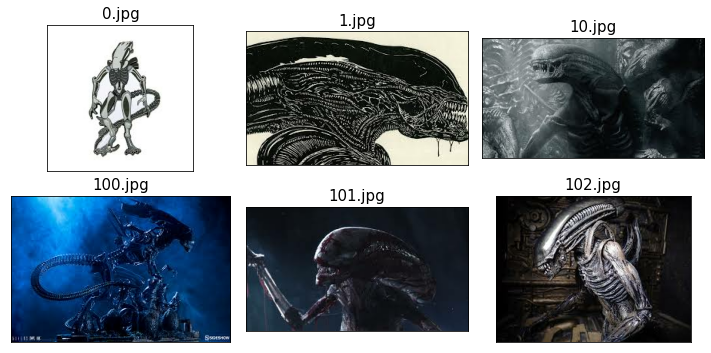

In [1]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np

train_alien_path = pathlib.Path('./data/train/alien')
train_pred_path = pathlib.Path('./data/train/predator')
test_alien_path = pathlib.Path('./data/validation/alien')
test_pred_path = pathlib.Path('./data/validation/predator')

# File name lists
alien_train_list = sorted([str(path) for path in train_alien_path.glob('*.jpg')])
pred_train_list = sorted([str(path) for path in train_pred_path.glob('*.jpg')])
alien_test_list = sorted([str(path) for path in test_alien_path.glob('*.jpg')])
pred_test_list = sorted([str(path) for path in test_pred_path.glob('*.jpg')])

#seperate into train and test files
train_file_list = alien_train_list + pred_train_list 
print(len(train_file_list))
test_file_list = alien_test_list + pred_test_list

fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(train_file_list[:6]): # Just show first 6 aliens
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
plt.tight_layout()
plt.show()

### Input function for train dataset

In [2]:
train_labels = [1 if 'alien' in file else 0 for file in train_file_list]

def make_train_dataset():
    ds_files_labels = tf.data.Dataset.from_tensor_slices(
        (train_file_list, train_labels))

    def load_and_preprocess(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image /= 255.0

        return {'conv2d_input': image}, label

    img_width, img_height = 120, 80

    ds_train = ds_files_labels.map(load_and_preprocess)
    
    tf.random.set_seed(1)

    return ds_train.shuffle(buffer_size=150, reshuffle_each_iteration=False)

### Input function for validation dataset

In [3]:
test_labels = [1 if 'alien' in file else 0 for file in test_file_list]

def make_test_dataset():
    ds_files_labels = tf.data.Dataset.from_tensor_slices(
        (test_file_list, test_labels))

    def load_and_preprocess(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image /= 255.0

        return {'conv2d_input': image}, label

    img_width, img_height = 120, 80

    ds_test = ds_files_labels.map(load_and_preprocess)
    
    tf.random.set_seed(1)

    return ds_test.shuffle(buffer_size=150, reshuffle_each_iteration=False)

## TensorFlow Model Creation

create a custom TensorFlow DNN model using the Keras API

In [4]:
# define appropriate feature columns for the input to the model
features = [
    tf.feature_column.numeric_column(
        key='conv2d_input:', shape=(80, 120, 3))
]

In [5]:
#build the model
model = tf.keras.Sequential()

# input feture columns
model.add(
    tf.keras.layers.Input(shape=(80, 120, 3), name='conv2d_input'))

model.add(
    tf.keras.layers.Conv2D(4, (3,3), data_format= "channels_last", input_shape = (80, 120, 3), activation="relu"))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides = 3, padding = 'same', name='pool_1'))

model.add(
    tf.keras.layers.Conv2D(4, (3,3), activation = 'tanh'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2'))

model.add(
    tf.keras.layers.Conv2D(4, (3,3), activation = 'relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_3'))

model.add(
    tf.keras.layers.Dense(units=32, activation = "relu"))

model.add(
    tf.keras.layers.Dense(units=16, activation = "relu", kernel_regularizer='l2'))

model.add(
    tf.keras.layers.Flatten())

model.add(
    tf.keras.layers.Dense(units = 1))

In [6]:
## printing variables of the model
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)
    
model.summary()

conv2d/kernel:0      True (3, 3, 3, 4)
conv2d/bias:0        True (4,)
conv2d_1/kernel:0    True (3, 3, 4, 4)
conv2d_1/bias:0      True (4,)
conv2d_2/kernel:0    True (3, 3, 4, 4)
conv2d_2/bias:0      True (4,)
dense/kernel:0       True (4, 32)
dense/bias:0         True (32,)
dense_1/kernel:0     True (32, 16)
dense_1/bias:0       True (16,)
dense_2/kernel:0     True (640, 1)
dense_2/bias:0       True (1,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 118, 4)        112       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 40, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 38, 4)         148       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 19,

### Description of Choices

We kept the default `kernel_initializer` as `glorotUniform`  because it draws samples from a truncated normal distribution centered on 0 and there was no prevailing reason to change from the default.  

`L2` regularization was used because `L2` gives better prediction when the output variable is a function of all input features and because `L1` cannot learn complex patterns.

`Adam` was the chosen optimizer because combines the advantages of two `SGD` extensions — Root Mean Square Propagation (`RMSProp`) and Adaptive Gradient Algorithm (`AdaGrad`) — and computes individual adaptive learning rates for different parameters.

`BinaryCrossentropy` is the standard loss function for binary image classification, so that was a given.

And `BinaryAccuracy` was selected for metrics because our choices of *alien vs. predator* was easily classified as *1 vs. 0*.

The depth of our images is 3, as each image is read in by using red, green, and blue color channels. This seemed like the obvious choice, as 3 in pretty standard. That's what a printer uses, so it should work for us. 

The depth of our model is 11, as there are 11 layers added to the model. The widest layer has 32 units; however we also used units 4, 16, and 1. It's better that our model is more wide than it is deep, as deep models are prone to vanishing gradients, making them harder to train. After a lot of trial and error, the model preformed the best when most (but not all) of the units were set to 4.  


#### Citations 

[Keras - Layer Weight Initializers](https://keras.io/api/layers/initializers/)

[Medium - Adam vs SDG](https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34#:~:text=SGD%20is%20a%20variant%20of,random%20selection%20of%20data%20examples.&text=Essentially%20Adam%20is%20an%20algorithm,optimization%20of%20stochastic%20objective%20functions.)

[Medium - L1 vs L2](https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2)


### Compile the Model

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


### Fit the Model 
This needs to be done before creating the estimator for graphing purposes 

In [8]:
epoch = 200
batch_size = 64 
steps_per_epoch = np.ceil(len(train_file_list) / batch_size)

tf.random.set_seed(314)

traindata = make_train_dataset()
ds_train = traindata.skip(150).batch(batch_size)
ds_valid = traindata.take(150).batch(batch_size)

ds_test = make_test_dataset().batch(batch_size)

In [9]:
history = model.fit(ds_train, epochs=epoch, 
                    validation_data=ds_valid, 
                    shuffle=False,
                    verbose=1)

Epoch 1/200
9/9 [==============================] - 1s 117ms/step - loss: 1.6862 - binary_accuracy: 0.6379 - val_loss: 2.1320 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 1s 100ms/step - loss: 1.0162 - binary_accuracy: 0.6379 - val_loss: 1.3725 - val_binary_accuracy: 0.0400
Epoch 3/200
9/9 [==============================] - 1s 103ms/step - loss: 0.9110 - binary_accuracy: 0.5846 - val_loss: 1.1668 - val_binary_accuracy: 0.2600
Epoch 4/200
9/9 [==============================] - 1s 102ms/step - loss: 0.8578 - binary_accuracy: 0.6305 - val_loss: 1.2505 - val_binary_accuracy: 0.1667
Epoch 5/200
9/9 [==============================] - 1s 101ms/step - loss: 0.8368 - binary_accuracy: 0.6618 - val_loss: 1.3571 - val_binary_accuracy: 0.0133
Epoch 6/200
9/9 [==============================] - 1s 100ms/step - loss: 0.8384 - binary_accuracy: 0.6379 - val_loss: 1.3805 - val_binary_accuracy: 0.0000e+00
Epoch 7/200
9/9 [==============================] - 1s 95ms/ste

9/9 [==============================] - 1s 100ms/step - loss: 0.6052 - binary_accuracy: 0.7132 - val_loss: 1.2563 - val_binary_accuracy: 0.2400
Epoch 54/200
9/9 [==============================] - 1s 101ms/step - loss: 0.5888 - binary_accuracy: 0.7316 - val_loss: 1.3263 - val_binary_accuracy: 0.2067
Epoch 55/200
9/9 [==============================] - 1s 101ms/step - loss: 0.6035 - binary_accuracy: 0.7114 - val_loss: 1.2350 - val_binary_accuracy: 0.2733
Epoch 56/200
9/9 [==============================] - 1s 100ms/step - loss: 0.5800 - binary_accuracy: 0.7445 - val_loss: 1.4140 - val_binary_accuracy: 0.2133
Epoch 57/200
9/9 [==============================] - 1s 100ms/step - loss: 0.6033 - binary_accuracy: 0.7096 - val_loss: 1.2144 - val_binary_accuracy: 0.3000
Epoch 58/200
9/9 [==============================] - 1s 101ms/step - loss: 0.5717 - binary_accuracy: 0.7463 - val_loss: 1.4340 - val_binary_accuracy: 0.2200
Epoch 59/200
9/9 [==============================] - 1s 101ms/step - loss: 0.6

9/9 [==============================] - 1s 104ms/step - loss: 0.5019 - binary_accuracy: 0.7776 - val_loss: 1.7271 - val_binary_accuracy: 0.4933
Epoch 106/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4980 - binary_accuracy: 0.7812 - val_loss: 1.7498 - val_binary_accuracy: 0.4867
Epoch 107/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4993 - binary_accuracy: 0.7776 - val_loss: 1.7282 - val_binary_accuracy: 0.4933
Epoch 108/200
9/9 [==============================] - 1s 105ms/step - loss: 0.4936 - binary_accuracy: 0.7812 - val_loss: 1.8152 - val_binary_accuracy: 0.4733
Epoch 109/200
9/9 [==============================] - 1s 106ms/step - loss: 0.4963 - binary_accuracy: 0.7757 - val_loss: 1.7937 - val_binary_accuracy: 0.5000
Epoch 110/200
9/9 [==============================] - 1s 105ms/step - loss: 0.4904 - binary_accuracy: 0.7831 - val_loss: 1.8197 - val_binary_accuracy: 0.4733
Epoch 111/200
9/9 [==============================] - 1s 107ms/step - los

9/9 [==============================] - 1s 105ms/step - loss: 0.4252 - binary_accuracy: 0.8217 - val_loss: 2.0579 - val_binary_accuracy: 0.5400
Epoch 158/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4253 - binary_accuracy: 0.8199 - val_loss: 2.0532 - val_binary_accuracy: 0.5400
Epoch 159/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4228 - binary_accuracy: 0.8217 - val_loss: 2.0625 - val_binary_accuracy: 0.5400
Epoch 160/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4225 - binary_accuracy: 0.8217 - val_loss: 2.0586 - val_binary_accuracy: 0.5400
Epoch 161/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4201 - binary_accuracy: 0.8217 - val_loss: 2.0714 - val_binary_accuracy: 0.5400
Epoch 162/200
9/9 [==============================] - 1s 104ms/step - loss: 0.4200 - binary_accuracy: 0.8199 - val_loss: 2.0765 - val_binary_accuracy: 0.5400
Epoch 163/200
9/9 [==============================] - 1s 104ms/step - los

## TensorFlow Estimator Creation and Training

Take the compiled model created in the third section and use it to create a custom Keras Estimator

In [10]:
## Define the input functions
def train_input_fn():
    return make_train_dataset().batch(batch_size)
    
def eval_input_fn():
    return make_test_dataset().batch(batch_size)

In [11]:
# Create the estimator: convert from a Keras model
my_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ql/r83_hjqs48v5n3xl8gs8p3f8yg10d_/T/tmp3sgwwd0w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '

In [12]:
# train it against the training data created in part two
my_estimator.train(
    input_fn=lambda: train_input_fn(), 
    steps=epoch * steps_per_epoch)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/var/folders/ql/r83_hjqs48v5n3xl8gs8p3f8yg10d_/T/tmp3sgwwd0w/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: /var/folders/ql/r83_hjqs48v5n3xl8gs8p3f8yg10d_/T/tmp3sgwwd0w/keras/keras_model.ckpt
INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.
INFO:tensorflow:Warm-started 12 variables.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0

## Tensorflow Estimator Performance

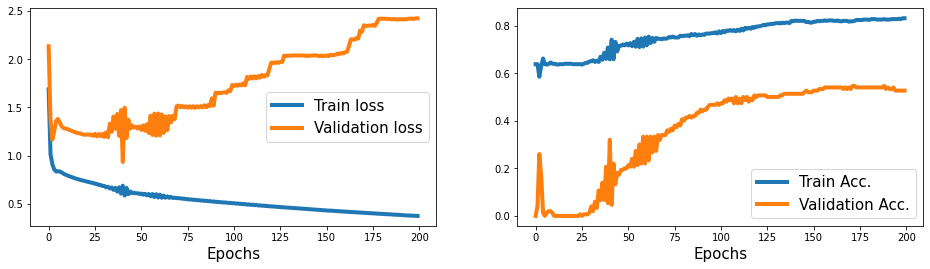

In [13]:
import numpy as np
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(hist['loss'], lw=4)
plt.plot(hist['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(hist['binary_accuracy'], lw=4)
plt.plot(hist['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plt.show()

In [14]:
# evaluate
eval_results = my_estimator.evaluate(
    input_fn=lambda: eval_input_fn(),
    steps=epoch * steps_per_epoch)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-25T18:57:34Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ql/r83_hjqs48v5n3xl8gs8p3f8yg10d_/T/tmp3sgwwd0w/model.ckpt-11
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.39331s
INFO:tensorflow:Finished evaluation at 2020-08-25-18:57:35
INFO:tensorflow:Saving dict for global step 11: binary_accuracy = 0.765625, global_step = 11, loss = 1.1954811
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11: /var/folders/ql/r83_hjqs48v5n3xl8gs8p3f8yg10d_/T/tmp3sgwwd0w/model.ckpt-11


In [15]:
print('\nTest Acc. {:.2f}%'.format(eval_results['binary_accuracy']*100))


Test Acc. 76.56%


### Summarize Findings

With all the work that went into this project, we are beyond pleased with the results. As you can see in the the training accuracy from model.fit() gets up to about 85%, and with the validation accuracy we see steady improvement, showing the model is learning, caping out just over 50%.

As for loss, the training dataset shows a sharp and then steady decrease and the validation dataset shows a decrease than then increase. Meaning the algorithm was penalized for a bad prediction.

Our ending accuracy using the estimator on out test dataset was 76.56%, so not too bad! Overall, I'd say out model works fairly decently. 